# Merging taxonomy w/ ARG types

Documentation:
The goal of this workbook is to merge taxonomy, gene_ID, contig_ID, and antibiotic resistance gene information into a single flat file.

The file inputs:
xx_MyTaxa_Input.txt -> Links gene_ID and contig_ID (gene_to_contig)
xx_MyTaxa_Output.txt -> Links contig_ID & taxonomy (contig_to_tax)
xx_sub_dict_output -> Links gene_ID & ARG_type (full_data)

Done:
Directory import
Matching
Some tests (uniqueness and size of unions)
Plotting percent classification


Notes/to do:
Transfer to script that takes command line arguments


### Function definitions

In [120]:


def add_Taxonomy(full_data_df, contig_to_tax_df):
    """ Adds taxonomy to full_data_df. Handles missing values in contig column by appending "Unclassified" to 
    full_data_w_taxonomy.

Inputs
    full_data_df     [DataFrame] - Contains a column contig that may contain missing values.
    contig_to_tax_df [DataFrame] - Dataframe with contigs in column (Name) & 8 taxonomy columns.
    
Returns
    full_data_w_tax: [pandas DataFrame] - Updated full_data_df with taxonomy columns.
    """
    
    # Initialize timer & new dataframe with taxonomy columns.
    start = time.time()
    ind=0
    new_cols = full_data_df.columns.values.tolist() +  contig_to_tax_df.columns[1:].values.tolist()
    full_data_w_tax = pd.DataFrame(index=full_data_df.index, columns=new_cols)
    contigs = full_data_df['contig']
    
    # Iterate thru rows and add taxonomy.
    for i in full_data.iterrows():
        original_values =  i[1].values.tolist()
        # Exception handling for missing taxonomy.
        try:
            taxonomy_list = contig_to_tax[contig_to_tax['Name'] == i[1].contig].ix[:,1:].values.tolist()[0]
        except IndexError:
            taxonomy_list = ['Unclassified']*8

        full_row_w_tax = original_values + taxonomy_list
        full_data_w_tax.ix[i[0],:] = full_row_w_tax
    
    # Progress indicator
        ind+=1
        if ind%10000==0:
            now = time.time()
            elapsed = now - start
            print '{0} complete!\n Total time = {1} seconds'.format(ind, elapsed)

    
    return full_data_w_tax


def add_Gene_IDs(gene_to_contig_df, full_df, gene_col, contig_col):
    """ Adds the gene_IDs in gene_to_contig to the full dataframe. First dereplicates gene_to_contig, 
    then generates a list of contigs from the gene_indexes in full dataframe.
    Lastly, appends contig_ids to the full dataframe. 
    
    Returns modified full_df.
    """
    
    # Remove duplicates from the gene_to_contig dataframe
    gene_to_contig_abridged = gene_to_contig_df.groupby([gene_col, contig_col]).count()
    
    # Save dereplicated results as a dataframe and reset index.
    gtca = pd.DataFrame(gene_to_contig_abridged.to_records())
    gtca.set_index(gene_col, inplace=True)

    # Get a list of the indexes for the gene-to-contig dataframe.
    gene_IDs = full_df['qseq_ID'].values.tolist()
    contigs_column = gtca.loc[gene_IDs][contig_col].values
    full_df['contig'] = contigs_column  
    
    return full_df


def directory_Import(directory):
    """ Template for automating directory import. Assumes it contains at least the 3 files used in this workbook."""
    
    files_list = glob.glob(directory)
    for i in files_list:
        if   'MyTaxa_Input' in i:
            gene_to_contig = pd.read_csv(i, sep="\t", header=None, names=['gene_ID', 'sseqid', 'pident', \
            'length', 'mismatch', 'gapopen', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore', \
            'contig_ID', 'gene_ID2', 'thing'], index_col=1) 
            
        elif 'Output_Sorted' in i:
            contig_to_tax = pd.read_csv(i, sep="\t", header=0, index_col=0)
        elif 'dict_output' in i:
            full_data = pd.read_csv(i, sep="\t", header=0)
    return gene_to_contig, contig_to_tax, full_data

def test_Unique(df, column):
    """ Tests to see if a column of a dataframe contains repeated values"""
    df_len = len(df)
    col_len = len(df[column].unique())
    print "Dataframe length: {0}\nUnique entries in column [{1}]: {2}\n".format(
                            df_len, column, col_len)
    return df_len == col_len

def Union_Between_Dataframes(df1, df2, col_1, col_2):
    """ Tests for the size of the union between df1[col2] and df2[col2] """
    df1_ids = set(df1[col_1].values.tolist())
    df2_ids = set(df2[col_2].values.tolist())
    
    union = len(set.union(df1_ids, df2_ids))
    print "df_1: {0}\ndf_2: {1}\nUnion size: {2}".format(len(df1), len(df2), union)
    return union

### Imports

In [6]:
# imports
import pandas as pd
import numpy as np
import time
import glob

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2
%matplotlib inline

### Main

In [5]:
# import data
ex_directory = "/Users/jimbo/Documents/Work/George_Wells_lab/Projects/ARG_metagenome/Classifying_ARG_taxonomy/data/*"
gene_to_contig, contig_to_tax, full_data = directory_Import(ex_directory)

# Add contig to full_data.
full_data = add_Gene_IDs(gene_to_contig, full_data, 'gene_ID', 'contig_ID')


# Skip tax assignment if full_data_w_tax already exists in directory
try:
    full_data_w_tax = pd.read_csv('./data/full_data_w_tax.txt', sep="\t")
except:
    pass
    
if full_data_w_tax is None:
# Add taxonomy to full_data
    full_data_w_tax = add_Taxonomy(full_data, contig_to_tax)
    full_data_w_tax.to_csv("./data/full_data_w_tax.txt", sep="\t")

/Users/jimbo/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [122]:
shortened_data = add_Gene_IDs(gene_to_contig, arg_genes_unfucked, 'gene_ID', 'contig_ID')
shortened_data['contig'].value_counts()

contig00909    3
contig00151    1
contig00126    1
contig00552    1
contig00866    1
contig00083    1
contig00171    1
contig00762    1
contig00634    1
Name: contig, dtype: int64

# Plotting classification rate

In addition to merging the raw classification data, it would be useful to know what percent of ARG genes can be assigned to taxonomy based on the current myTaxa contig classification strategy. From last week's glance, it seems like a lot of ARG contigs were not taxonomically classified but I'd like to understand this in more detail. 

I also would like to get a sense of (real or artificial) enrichment of ARGs in certain taxa. For this we can plot the ARG taxa classification vs the bulk contig classification and see how they differ. This might not actually make sense with the files I have depending on what processing has already been applied to the contig classification file but the plotting code should be useful regardless.

Output:
1. Quick stats about overlap between contigs, gene_IDs and taxonomy. # of Unique values of each per file, distribution and overlap between file types.

2. Plot of ARG taxa classification and contig classification + difference by phyla


In [80]:
# Random comparisons I was doing to see how many unique values there are and if they overlap.

### Testing repeated entries
test_Unique(full_data,  'qseq_ID')
test_Unique(contig_to_tax, 'Name')
test_Unique(gene_to_contig, 'gene_ID')
test_Unique(gene_to_contig, 'contig_ID')

# Size of union
Union_Between_Dataframes(full_data, gene_to_contig, 'qseq_ID', 'gene_ID')

Dataframe length: 55666
Unique entries in column [qseq_ID]: 2546

Dataframe length: 680
Unique entries in column [Name]: 680

Dataframe length: 752450
Unique entries in column [gene_ID]: 2248

Dataframe length: 752450
Unique entries in column [contig_ID]: 746

df_1: 55666
df_2: 752450
Union size: 4682


4682

### Part II Functions

In [ ]:
def prepare_Qiime_Barplot(rRNA_path, sample_ID, cutoff):
    """ Takes:
    rRNA_path: taxonomy summary filepath produced by QIIME summarize_taxa.py
    sample_ID: column header in taxonomy file
    cutoff: Threshold for including taxa in barplot.
    
    Returns: Tabular data to be plotted next to ARG data.
    """
    
    # Import data
    rRNA_only_data = pd.read_csv(rRNA_path, sep="\t", header=1, index_col=0)
    rRNA_subset = rRNA_only_data.ix[rRNA_only_data[sample_ID] > cutoff]
    rRNA_subset = rRNA_subset[sample_ID].sort_values(ascending=False)

    return rRNA_subset # Or just make a call to a plotting function.

### Part II Main

In [ ]:
rRNA_path = "../16s_tax_class/qiime_labeled/clustered_first/tax_sum/otu_table_L3.txt"
rRNA_only_data = pd.read_csv(rRNA_path, sep="\t", header=1, index_col=0)
rRNA_subset = rRNA_only_data.ix[rRNA_only_data['BF3'] >.005]


rRNA_sub = prepare_Qiime_Barplot(rRNA_path, 'BF3', .005)
rRNA_tax_names = [x.split("__")[-1] for x in rRNA_sub.index]
#rRNA_sub.ix[:,'names'] = rRNA_tax_names

In [112]:
# I just want to get some super simple shit working before I send it.

#the file morgan sent was the full_dict file after removing duplicates.
arg_genes_unfucked = pd.read_csv("/Users/jimbo/Downloads/BF3_bh_10_70_50_aa_sub_dict_output.txt", sep="\t", header=0)
test_Unique(arg_genes_unfucked, 'qseq_ID')

Dataframe length: 107
Unique entries in column [qseq_ID]: 107



True

In [ ]:
# 3 part venn diagram->
# A. gene_ids in full_data,
# B. gene_ids in myTaxa_in
# C. # of Contigs w/ ta
# contigs in myTaxa output

In [64]:
# gathering abundances by taxonomic classification level.

# unknown = myTaxa tried and could not assign taxonomy at this level
# unclassified = Contig was missing from myTaxa_output file.

#phyla_abundances = full_data_w_tax[
#full_data_w_tax['<phylum>']
taxonomic_levels = ['<superkingdom>', '<phylum>',
       '<class>', u'<order>', u'<family>', u'<genus>', u'<species>',
       u'<superphylum>']


full_data_w_tax[taxonomic_levels[2]].value_counts()['Unclassified']#/len(full_data_w_tax)

53392

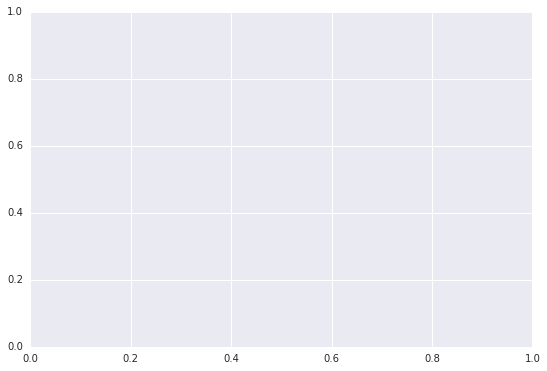

In [50]:
def bar_Plot_Classification():
    return

unclassified = full_data_w_tax[taxonomic_levels[1]].value_counts()['Unclassified']/float(len(full_data_w_tax))
classified = 1 - unclassified

print "Total ARG hits: {0}".format(len)
print "Percent of found ARGS on contigs assigned to taxonomy"


('unknown', 1218)
('Gammaproteobacteria', 720)
('Bacilli', 96)
('Spirochaetia', 74)
('Epsilonproteobacteria', 60)
('Bacteroidia', 55)
('Clostridia', 40)
('Deltaproteobacteria', 5)
('Negativicutes', 3)
('Alphaproteobacteria', 3)


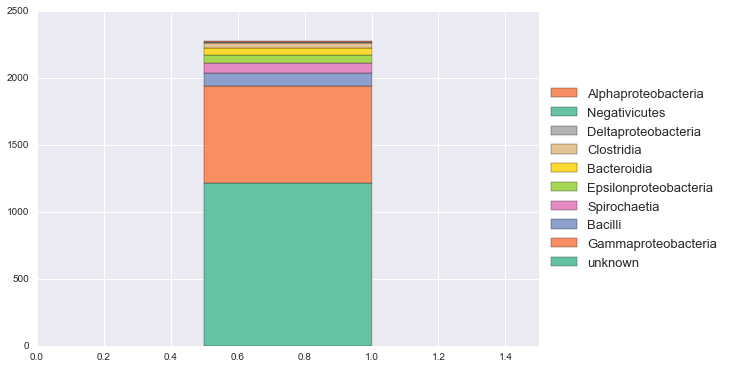

In [65]:
# %Classified, annotate plot with this.
unclassified = full_data_w_tax[taxonomic_levels[1]].value_counts()['Unclassified']/float(len(full_data_w_tax))
classified = 1 - unclassified




# barplot
series = full_data_w_tax[taxonomic_levels[2]].value_counts()
series_length = series[1:].sum()

colors = sns.color_palette('Set2', 10)

last=0
j=0
f,ax = plt.subplots()
for i in series[1:].iteritems():
    print i
    ax.bar(.5, i[1], width=.5, bottom = last, label=i[0], color=colors[j])
    last = last + i[1]
    j+=1
ax.set_xlim([0,1.5])


# Put a legend to the right of the current axis
handles, labels = ax.get_legend_handles_labels()
handles.reverse()
labels.reverse()
lgd = ax.legend(handles=handles, labels=labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=13)


plt.show()

unknown                  0.022812
Gammaproteobacteria      0.013485
Bacilli                  0.001798
Spirochaetia             0.001386
Epsilonproteobacteria    0.001124
Bacteroidia              0.001030
Clostridia               0.000749
Deltaproteobacteria      0.000094
Negativicutes            0.000056
Alphaproteobacteria      0.000056
Name: <class>, dtype: float64
Gammaproteobacteria      0.591133
Bacilli                  0.078818
Spirochaetia             0.060755
Epsilonproteobacteria    0.049261
Bacteroidia              0.045156
Clostridia               0.032841
Deltaproteobacteria      0.004105
Negativicutes            0.002463
Alphaproteobacteria      0.002463
Name: <class>, dtype: float64


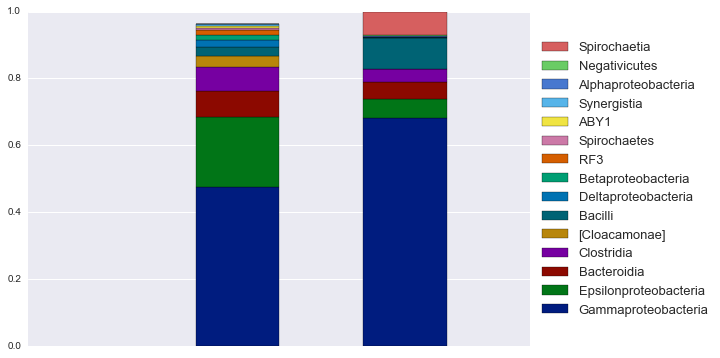

In [107]:
from_rRNA = pd.DataFrame(index=rRNA_tax_names, data = rRNA_sub.values, columns=['Relative_16S'])
from_rRNA
series = full_data_w_tax[taxonomic_levels[2]].value_counts()
#print series
series = series[2:]/series[2:].sum()
#print series
series_as_df = pd.DataFrame(index=series.index, data=series.values, columns=['ARG Taxonomy'])
#print series_as_df
rRNA_and_ARG = from_rRNA.join(series_as_df, how='outer')
#print rRNA_and_ARG
rRNA_and_ARG.sort_values('Relative_16S', ascending=False, inplace=True)


f,ax = plt.subplots()
names = rRNA_and_ARG.index
last_left=0
last_right=0
j=0

colors = sns.color_palette('Set2', len(rRNA_and_ARG))
rRNA_and_ARG.fillna(value=0, inplace=True)

for i in rRNA_and_ARG.iterrows():
    ax.bar(1, i[1][0], width=.5, bottom = last_left, label=i[0], color=cmap[j])
    ax.bar(2, i[1][1], width=.5, bottom = last_right, color=cmap[j])
    last_left = i[1][0] + last_left
    last_right = i[1][1] + last_right
    j+=1

handles, labels = ax.get_legend_handles_labels()
handles.reverse()
labels.reverse()
ax.set_xlim([0,3])
ax.set_xticks([])
lgd = ax.legend(handles=handles, labels=labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=13)

plt.show()
    

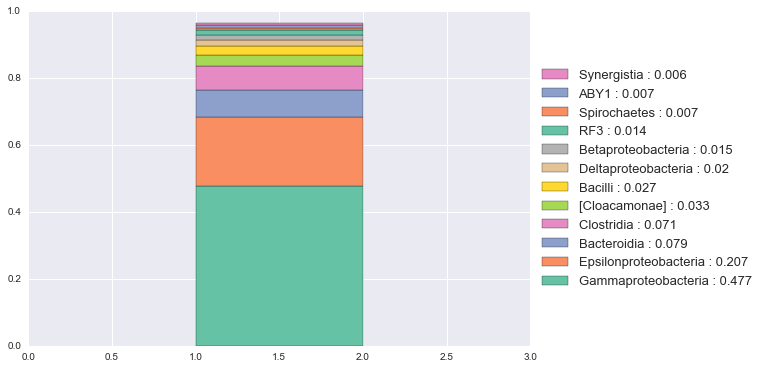

In [68]:
### importing 16s data from metagenome classification:

# re-order by size.
rRNA_subset = rRNA_subset['BF3'].sort_values(ascending=False)

# init colors
colors = sns.color_palette('Set2', 12)

# stacked bar plot
last=0
j=0
f,ax=plt.subplots()
for i in rRNA_subset.iteritems():
    name = i[0].split("__")[-1]
    ax.bar(1, i[1], width=1, bottom = last, label=name+" : "+str(round(i[1],3)), color=cmap[j])
    last = last + i[1]
    j+=1
ax.set_xlim([0,3])
    
handles, labels = ax.get_legend_handles_labels()
handles.reverse()
labels.reverse()
lgd = ax.legend(handles=handles, labels=labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=13)


In [40]:
round(.0116543,3)

0.012

In [41]:
?round

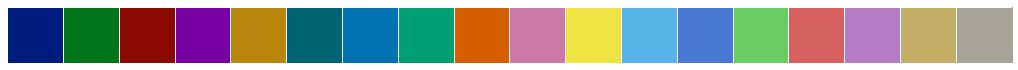

In [102]:
cmap = sns.color_palette('dark', n_colors=6)
cmap2 = sns.color_palette('colorblind', n_colors=6)
cmap3 = sns.color_palette('muted', n_colors=6)
cmap = cmap + cmap2 + cmap3[:-1] + sns.xkcd_palette(["greyish"])
#random.shuffle(cmap)
sns.palplot(cmap)